 Classification is one of the most basic yet most powerful concepts. Let’s look at how classification is set up by a computer vision model:
1.	Detecting edges
2.	Detecting gradients
3.	Identifying textures
4.	Identifying patterns
5. Forming parts of objects

We will be checking x-ray images of lungs and classifying them, with the help of computer vision modeling techniques, as either having pneumonia or being normal. Since this is a healthcare problem it is always best to let the model overpredict. We need to predict with the highest form of accuracy and should have nearly 100% recall if possible, with a high precision score as well. 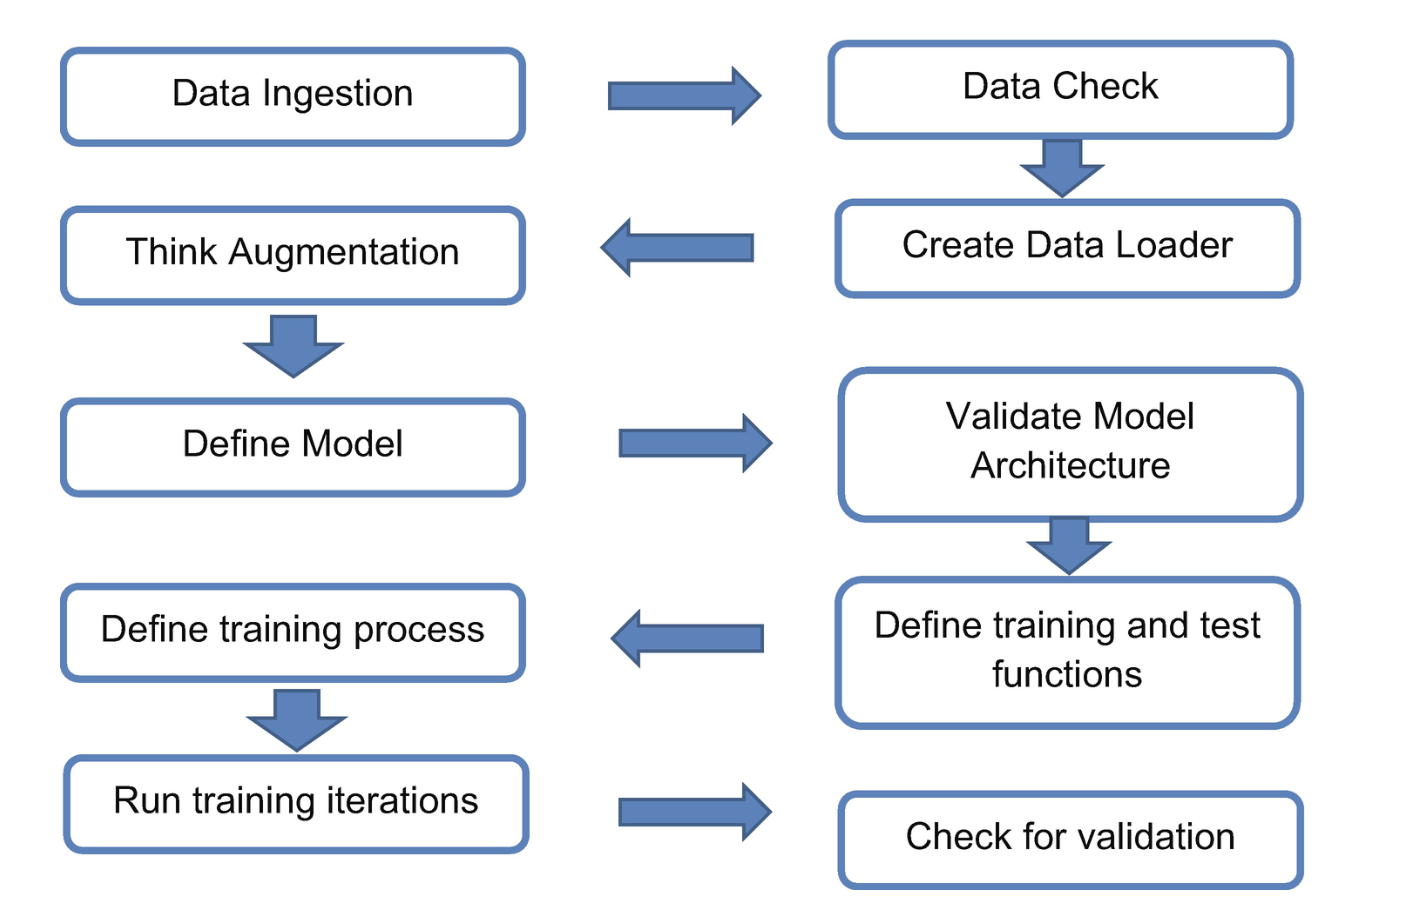



The dataset is divided into test and train folders, with each further divided into NORMAL and PNEUMONIA categories.
- The number of train samples in the NORMAL category is 1349.

- The number of train samples in the PNEUMONIA category is 3883.

- The number of test samples in the NORMAL category is 234.

- The number of test samples in the PNEUMONIA category is 390.

## Imports

In [4]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [5]:
data_path = '/content/data/chest_xray'

## Explore data

In [6]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [7]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


Now that we have extracted the images and located the path, let’s see how to view the sample images from NORMAL and PNEUMONIA folders.

(970, 1302)


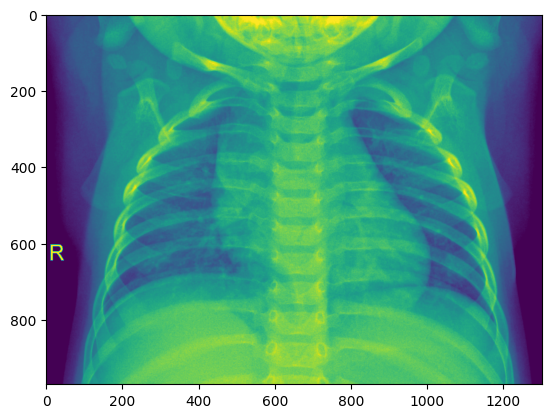

In [8]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1008, 1240)


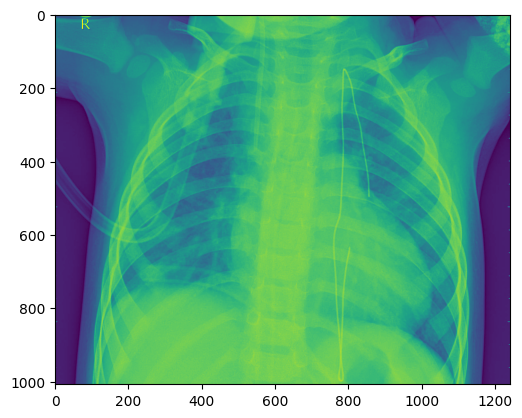

In [9]:
## get random file to check pneumona
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

## DATA LOADERS

In [10]:
train_transform = transforms.Compose([

    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [11]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 4, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## Define the Model
We will define our model architecture with convolution blocks and use ReLU as an activation layer. The baseline model will have 12 convolution blocks, including one convolution block to set up the input and one for the output. The first three convolution blocks have one max pooling function to drop down from the high dimensions of the image to lower dimensions by filtering information.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.pool22 = nn.MaxPool2d(2, 2)


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2, 2)


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(32),

        )


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),

        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)

        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)

        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)

        )

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)

        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             R

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## The Training Process
After defining the model and the data loader, we have come down to training. The training process will include the following important processes:



In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements

        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    #val_loss =
    test(model, device, test_loader)

EPOCH number: 0


Loss=0.1445828080177307 Batch_id=1307 Accuracy=90.48: 100%|██████████| 1308/1308 [02:03<00:00, 10.58it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.4864, Accuracy: 518/624 (83.01%)

EPOCH number: 1


Loss=0.059970755130052567 Batch_id=1307 Accuracy=93.92: 100%|██████████| 1308/1308 [02:03<00:00, 10.63it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.5254, Accuracy: 517/624 (82.85%)

EPOCH number: 2


Loss=0.006022205110639334 Batch_id=1307 Accuracy=94.06: 100%|██████████| 1308/1308 [01:59<00:00, 10.95it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.4117, Accuracy: 528/624 (84.62%)

EPOCH number: 3


Loss=0.005075046792626381 Batch_id=1307 Accuracy=94.59: 100%|██████████| 1308/1308 [02:03<00:00, 10.56it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.7027, Accuracy: 502/624 (80.45%)

EPOCH number: 4


Loss=0.08550375699996948 Batch_id=1307 Accuracy=94.76: 100%|██████████| 1308/1308 [02:04<00:00, 10.50it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.4402, Accuracy: 525/624 (84.13%)

EPOCH number: 5


Loss=0.030621346086263657 Batch_id=1307 Accuracy=95.28: 100%|██████████| 1308/1308 [02:04<00:00, 10.51it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.5370, Accuracy: 517/624 (82.85%)

EPOCH number: 6


Loss=0.7702884674072266 Batch_id=1307 Accuracy=95.93: 100%|██████████| 1308/1308 [02:04<00:00, 10.50it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.4185, Accuracy: 542/624 (86.86%)

EPOCH number: 7


Loss=0.0013742640148848295 Batch_id=1307 Accuracy=96.16: 100%|██████████| 1308/1308 [02:02<00:00, 10.65it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.5140, Accuracy: 518/624 (83.01%)

EPOCH number: 8


Loss=0.004316565580666065 Batch_id=1307 Accuracy=95.95: 100%|██████████| 1308/1308 [02:02<00:00, 10.65it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.5135, Accuracy: 535/624 (85.74%)

EPOCH number: 9


Loss=0.019906887784600258 Batch_id=1307 Accuracy=96.37: 100%|██████████| 1308/1308 [01:59<00:00, 10.96it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.4407, Accuracy: 538/624 (86.22%)

EPOCH number: 10


Loss=0.003234224859625101 Batch_id=1307 Accuracy=96.20: 100%|██████████| 1308/1308 [02:00<00:00, 10.83it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.3559, Accuracy: 558/624 (89.42%)

EPOCH number: 11


Loss=0.01644311472773552 Batch_id=1307 Accuracy=95.89: 100%|██████████| 1308/1308 [02:04<00:00, 10.51it/s]


Current Learing Rate:  0.0025

Test set: Average loss: 0.3277, Accuracy: 565/624 (90.54%)

EPOCH number: 12


Loss=0.18839429318904877 Batch_id=1307 Accuracy=96.66: 100%|██████████| 1308/1308 [02:01<00:00, 10.75it/s]


Current Learing Rate:  0.0025

Test set: Average loss: 0.3744, Accuracy: 557/624 (89.26%)

EPOCH number: 13


Loss=0.03707914054393768 Batch_id=1307 Accuracy=96.60: 100%|██████████| 1308/1308 [02:01<00:00, 10.74it/s]


Current Learing Rate:  0.0025

Test set: Average loss: 0.5091, Accuracy: 530/624 (84.94%)

EPOCH number: 14


Loss=0.0026080068200826645 Batch_id=1307 Accuracy=96.88: 100%|██████████| 1308/1308 [02:02<00:00, 10.71it/s]


Current Learing Rate:  0.0025

Test set: Average loss: 0.3644, Accuracy: 553/624 (88.62%)



Text(0.5, 1.0, 'Test Accuracy')

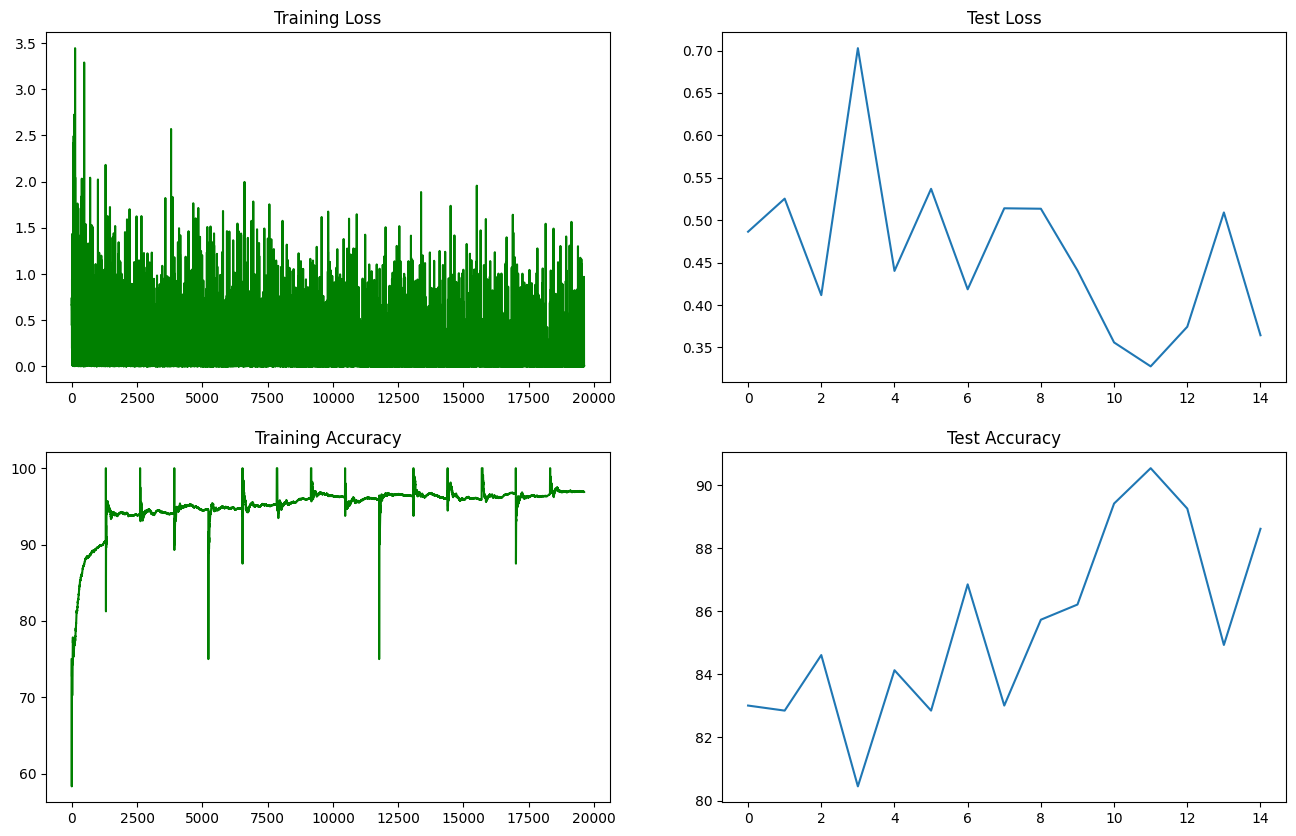

In [17]:
torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")